<a href="https://colab.research.google.com/github/Stecie06/COVID-19-Worldwide-Data-Analysis-using-SQL/blob/main/transfer_Learning_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

2.19.0


'/device:GPU:0'

In [ ]:
# Importing basic libraries
import os
import random
import shutil
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load Data set

Dataset Paths (adjust to where Kaggle dataset is extracted)
- The dataset folders look like:
- intel-image-classification/seg_train/seg_train
- intel-image-classification/seg_test/seg_test

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

# Base path in Google Drive
data_dir = "/content/drive/My Drive/intel-image-classification"

# Inner folders where the images actually reside
train_dir = '/content/drive/MyDrive/intel_image_classification/seg_train/seg_train'
test_dir  = '/content/drive/MyDrive/intel_image_classification/seg_test/seg_test'
 # optional

print("Train folder:", train_dir)
print("Test folder:", test_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train folder: /content/drive/MyDrive/intel_image_classification/seg_train/seg_train
Test folder: /content/drive/MyDrive/intel_image_classification/seg_test/seg_test


# Preprocessing

Perform any necesary preprocessing steps on the data

In [ ]:
# Parameters
IMG_SIZE = 224
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

# Load datasets
train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical",  # multiple classes
    shuffle=True
)

val_ds = image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# Number of classes
num_classes = len(train_ds.class_names)
print("Classes:", train_ds.class_names)

# Preprocessing function for VGG16
def preprocess(image, label):
  image=preprocess_input((tf.cast(image, tf.float32)))
  return image,label

train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE).shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## Transfer Learning

In [ ]:

# define cnn model
xy_shape3 = 224
BatchSize3 = 64
def deep_cnn_transfer_model():
    model = VGG16(include_top=False, input_shape=(xy_shape3, xy_shape3, 3))
    model.tansfer_learning = True
    # mark loaded layers as not trainable
    nb_layers = len(model.layers)
    print('nb_layers:',nb_layers)
    for layer in model.layers[1:20]: #[:nb_layers-5]:  #model.layers[1:20]
        layer.trainable=False
    # Add new classifier
    x = Flatten()(model.output)
    x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
    output = Dense(num_classes, activation='softmax')(x)  # softmax for multi-class

    # Define new model
    model = Model(inputs=model.inputs, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
conv_deep_transfer = deep_cnn_transfer_model()
conv_deep_transfer.summary()

nb_layers: 19


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,854 (68.39 MB)

 Trainable params: 3,212,166 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
EPOCHS = 2
history = conv_deep_transfer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/2
220/220 ━━━━━━━━━━━━━━━━━━━━ 1463s 3s/step - accuracy: 0.8346 - loss: 1.8162 - val_accuracy: 0.9027 - val_loss: 0.2924
Epoch 2/2
220/220 ━━━━━━━━━━━━━━━━━━━━ 137s 375ms/step - accuracy: 0.9600 - loss: 0.1320 - val_accuracy: 0.9097 - val_loss: 0.3429


In [ ]:
# evaluate model
loss, acc = conv_deep_transfer.evaluate(val_ds)
print(f"Validation Accuracy: {acc*100:.2f}%")


47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 335ms/step - accuracy: 0.9133 - loss: 0.3227
Validation Accuracy: 90.97%


# Make predictions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


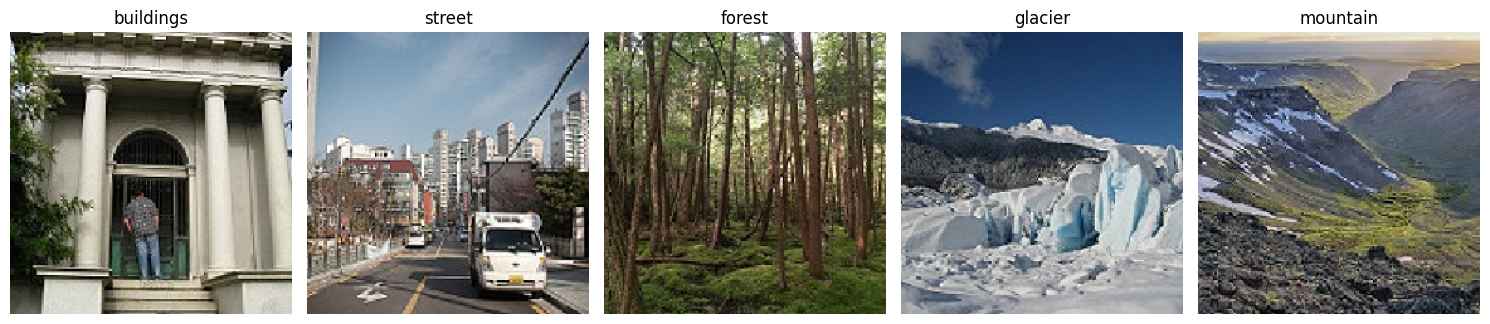

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input

# Path to prediction folder
pred_dir  = '/content/drive/MyDrive/intel_image_classification/seg_pred/seg_pred'
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# List all image files
image_files = os.listdir(pred_dir)

# Pick first 5 images
image_files = image_files[:5]

plt.figure(figsize=(15, 8))

for i, img_file in enumerate(image_files):
    img_path = os.path.join(pred_dir, img_file)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)  # convert to NumPy array for plotting
    img_array_exp = tf.expand_dims(img_array, 0)
    img_array_exp = preprocess_input(img_array_exp)

    # Predict
    preds = conv_deep_transfer.predict(img_array_exp)
    class_idx = np.argmax(preds, axis=1)[0]
    class_name = class_names[class_idx]

    # Plot
    plt.subplot(1, 5, i+1)
    plt.imshow(img_array.astype("uint8"))  # convert to uint8 for matplotlib
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Compare performance results

## Task: Work to improve the performance - try different strategies:
* Data Augmentation
* Hyperparameters tuning; lr, batch size, epocts, etc
* Test other models
  - eg. ResNet, Inception, Mobilenet, etc